<a href="https://colab.research.google.com/github/SebastianKropp/DisasterDetectionModel/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 144 Spring 2023 Project

Transformer model for disaster tweet detection.

Steps:

1. Preprocessing: Preprocess the text by tokenizing and converting the text to numerical representations using tokenizer from pretrained model.

2. Model Implementation: Implement a BERT model for detecting disaster tweets.

3. Model Evaluation: Train the model on the preprocessed dataset and evaluate its performance using accuracy, precision, recall, and F1-score. Experiment with different hyperparameters such as learning rate, batch size, and number of epochs to optimize the model's performance.

4. (Optional) Model Interpretation: Analyze the model's predictions by examining the most important features or words that contribute to a disaster or non-disaster tweet. (Optional: Visualize the results using techniques such as word clouds or attention maps).

Datasets: 

- Kaggle dataset: https://www.kaggle.com/competitions/nlp-getting-started/data
- Additional: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets?select=tweets.csv

## Dependencies and Imports

In [ ]:
!pip install transformers
!pip install sentencepiece sacremoses importlib_metadata
!pip install datasets

In [1]:
import pandas as pd
import random
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from datasets import load_dataset
import math
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

## Preprocessing
Preprocess the text by tokenizing and converting the text to numerical representations.

### Load Dataset

In [471]:
# Load the dataset from CSV
dataset_path = 'preprocessed_train.csv'  # Replace with the path to your dataset
dataset = pd.read_csv(dataset_path)
#dataset_extra = pd.read_csv('tweets.csv')

# Combine the additional columns into a feature matrix
features = dataset[['neutral', 'positive', 'negative', 'sarcastic']].values # for keywords probably have to do one hot encoding first since current code doesn't work with str values
num_extra_features = features.shape[1]

# Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels, train_features, test_features = train_test_split(dataset['text'], dataset['target'], features, test_size=0.2, random_state=42)

# Add dataset_extra to train data
#train_extra_texts = dataset_extra['text']  # Extract the text from the additional dataset
#train_extra_labels = dataset_extra['target']  # Extract the labels from the additional dataset

# Concatenate the additional dataset with the existing train data
#train_texts = pd.concat([train_texts, train_extra_texts])
#train_labels = pd.concat([train_labels, train_extra_labels])

# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Tokenization

In [472]:
def preprocess(texts, tokenizer, features=None):
  texts = texts.tolist() if isinstance(texts, pd.Series) else texts  # Convert to list if needed

  encoded_inputs = tokenizer(
    texts,
    padding='longest',
    truncation=True,
    max_length=512,
    return_tensors='pt',
    add_special_tokens=True
  )
  input_ids = encoded_inputs['input_ids'].to(device)
  attention_masks = encoded_inputs['attention_mask'].to(device)

  if not features is None:
    features_tensor = torch.tensor(features.tolist()).to(device)
    return input_ids, attention_masks, features_tensor

  return input_ids, attention_masks

In [ ]:
# Test preprocess()
test = train_texts[:2]
input_ids, attention_masks = preprocess(test, tokenizer)

# Print the first example
print("Text:", test.iloc[0])
print("Tokenized input:", tokenizer.convert_ids_to_tokens(input_ids[0].tolist()))
print("Input IDs:", input_ids[0])
print("Attention Mask:", attention_masks[0])

### Build DataLoaders

In [476]:
# ----- Build train dataset -----

# Preprocess the text data
train_input_ids, train_attention_masks, train_features_tensor = preprocess(train_texts, tokenizer, train_features)

# Convert train_labels to a list, then to a tensor
train_labels_tensor = torch.tensor(train_labels.tolist()).to(device)

# Build train dataset
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, train_features_tensor, train_labels_tensor)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# ------ Build test dataset -----

# Preprocess the text data
test_input_ids, test_attention_masks, test_features_tensor = preprocess(test_texts, tokenizer, test_features)

# Convert train_labels to a list, then to a tensor
test_labels_tensor = torch.tensor(test_labels.tolist()).to(device)

# Build test dataset
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks, test_features_tensor, test_labels_tensor)

In [477]:
# Define batch size
batch_size = 128

# Build DataLoaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Implementation
Implement model using a pre-trained model.

In [428]:
from transformers import AutoModel

In [491]:
%%capture

class CustomBERTOutput:
    def __init__(self, logits, hidden_states):
        self.logits = logits
        self.hidden_states = hidden_states

class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels, hidden_dim, dropout_rate):
        super(CustomBERTModel, self).__init__()

        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = torch.nn.Sequential(
            nn.Linear(config.hidden_size + num_extra_features, hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_labels)
        )

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
            
        combined_output = torch.cat((pooled_output, features), dim=1)

        logits = self.classifier(combined_output)

        return CustomBERTOutput(logits=logits, hidden_states=outputs.hidden_states)

# Number of labels
num_labels = 2

# Load the custom pre-trained model
hidden_dim = 1024
dropout_rate = 0.1
model1 = CustomBERTModel(model_name, num_labels, hidden_dim, dropout_rate)

model1.to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [492]:
%%capture

# Number of labels
num_labels = 2

# Load the pre-trained model
model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Download model and configuration from S3 and cache.
config = AutoConfig.from_pretrained(model_name)
last_state_dim = config.hidden_size

# Replace the pre-trained head with a new one.
model.classifier = torch.nn.Linear(last_state_dim, num_labels)

hidden_dim = 1024
dropout_rate = 0.1
#model2.classifier = torch.nn.Sequential(
#    nn.Linear(last_state_dim, hidden_dim),
#    nn.Tanh(),
#    nn.Dropout(dropout_rate),
#    nn.Linear(hidden_dim, num_labels)
#)

model2.to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

## Evaluation
Train the model on the preprocessed dataset and evaluate its performance using accuracy, precision, recall, and F1-score. Experiment with different hyperparameters such as learning rate, batch size, and number of epochs to optimize the model's performance.

### Train

In [483]:
def train_model(model, optimizer, criterion, trainloader, valloader, use_features=False):
  model.train()

  losses = []  # List to store the loss after each epoch
  accuracies = []
  val_accuracies = []
  best_val_accuracy = -1  # Initialize the best validation accuracy
  early_stopping_counter = 0  # Counter for early stopping
    
  for epoch in range(epochs):
      running_loss = 0.0
        
      for batch in trainloader:
          input_ids, attention_masks, features, labels = batch
          input_ids, attention_masks, features, labels = input_ids.to(device), attention_masks.to(device), features.to(device), labels.to(device)
            
          optimizer.zero_grad()
            
          # Forward pass
          if use_features:
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, features=features)
          else: 
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)

          if hasattr(outputs, 'logits'):
              # BERT model
              logits = outputs.logits.to(device)
              loss = criterion(logits, labels)
          else:
              # GPT model   
              logits = outputs.last_hidden_state[:, 0, :].to(device)        
              loss = criterion(logits, labels.long())

          # Backward pass and optimization
          loss.backward()
          #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

          optimizer.step()
          #scheduler.step()
          losses.append(loss.detach().cpu().numpy())

          # Calculate accuracy
          _, predicted_labels = torch.max(logits, dim=1)
          batch_accuracy = (predicted_labels == labels).sum().item() / labels.size(0)
          accuracies.append(batch_accuracy)

          # Uncomment to calculate validation accuracy (takes more time)
          val_accuracy, _, _, _, _ = evaluate_model(model, valloader, False, use_features=use_features)
          val_accuracies.append(val_accuracy)

      # Check if the current validation accuracy is better than the previous best
      if val_accuracy > best_val_accuracy:
          best_val_accuracy = val_accuracy
          early_stopping_counter = 0  # Reset the counter
      else:
          early_stopping_counter += 1  # Increment the counter

      print('Train Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.4f}\tValidation Accuracy: {:.4f}'.format(
        epoch, loss.item(), batch_accuracy, val_accuracy))
      #print('Train Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.4f}'.format(
      #  epoch, loss.item(), batch_accuracy))

      # Check if early stopping criterion is met
      if early_stopping_counter >= patience:
        print("Early stopping triggered. No improvement in validation accuracy for {} epochs.".format(patience))
        break

  return losses, accuracies, val_accuracies

In [493]:
# Define learning rate and number of epochs
learning_rate = 1e-5
epochs = 50
patience = 2

# Define the optimizer and criterion
optimizer1 = optim.AdamW(model1.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~80%
#optimizer1 = optim.RMSprop(model1.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~81% accuracy
#optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~80% accuracy

optimizer2 = optim.AdamW(model2.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~80%
#optimizer2 = optim.RMSprop(model2.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~81% accuracy
#optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate) # best learning rate: 1e-5, avg result: ~80% accuracy

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

# Define the scheduler to adjust learning rate
#scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(trainloader) * epochs)

In [494]:
# Train model1
losses1, accuracies1, val_accuracies1 = train_model(model1, optimizer1, criterion, trainloader, valloader, use_features=True)

Train Epoch: 0	Loss: 0.579600	Train Accuracy: 0.6667	Validation Accuracy: 0.6560
Train Epoch: 1	Loss: 0.626115	Train Accuracy: 0.8333	Validation Accuracy: 0.7118
Train Epoch: 2	Loss: 0.553572	Train Accuracy: 0.8333	Validation Accuracy: 0.7373
Train Epoch: 3	Loss: 0.404897	Train Accuracy: 1.0000	Validation Accuracy: 0.7594
Train Epoch: 4	Loss: 0.495980	Train Accuracy: 0.8333	Validation Accuracy: 0.7726
Train Epoch: 5	Loss: 0.264967	Train Accuracy: 1.0000	Validation Accuracy: 0.7816
Train Epoch: 6	Loss: 0.301229	Train Accuracy: 0.8333	Validation Accuracy: 0.7841
Train Epoch: 7	Loss: 0.560286	Train Accuracy: 0.8333	Validation Accuracy: 0.7841
Train Epoch: 8	Loss: 0.230903	Train Accuracy: 1.0000	Validation Accuracy: 0.7857
Train Epoch: 9	Loss: 0.797187	Train Accuracy: 0.6667	Validation Accuracy: 0.7841
Train Epoch: 10	Loss: 0.568934	Train Accuracy: 0.6667	Validation Accuracy: 0.7890
Train Epoch: 11	Loss: 0.545390	Train Accuracy: 0.6667	Validation Accuracy: 0.7882
Train Epoch: 12	Loss: 0.28

In [495]:
# Train model2
losses2, accuracies2, val_accuracies2 = train_model(model2, optimizer2, criterion, trainloader, valloader)

Train Epoch: 0	Loss: 0.694868	Train Accuracy: 0.5000	Validation Accuracy: 0.6445
Train Epoch: 1	Loss: 0.734396	Train Accuracy: 0.5000	Validation Accuracy: 0.6749
Train Epoch: 2	Loss: 0.609455	Train Accuracy: 0.8333	Validation Accuracy: 0.7069
Train Epoch: 3	Loss: 0.670948	Train Accuracy: 0.5000	Validation Accuracy: 0.7332
Train Epoch: 4	Loss: 0.484678	Train Accuracy: 0.8333	Validation Accuracy: 0.7529
Train Epoch: 5	Loss: 0.909237	Train Accuracy: 0.3333	Validation Accuracy: 0.7709
Train Epoch: 6	Loss: 0.676746	Train Accuracy: 0.6667	Validation Accuracy: 0.7808
Train Epoch: 7	Loss: 0.357155	Train Accuracy: 1.0000	Validation Accuracy: 0.7956
Train Epoch: 8	Loss: 0.315386	Train Accuracy: 1.0000	Validation Accuracy: 0.7964
Train Epoch: 9	Loss: 0.606489	Train Accuracy: 0.6667	Validation Accuracy: 0.7997
Train Epoch: 10	Loss: 0.469661	Train Accuracy: 0.6667	Validation Accuracy: 0.8046
Train Epoch: 11	Loss: 0.195736	Train Accuracy: 1.0000	Validation Accuracy: 0.7841
Train Epoch: 12	Loss: 0.17

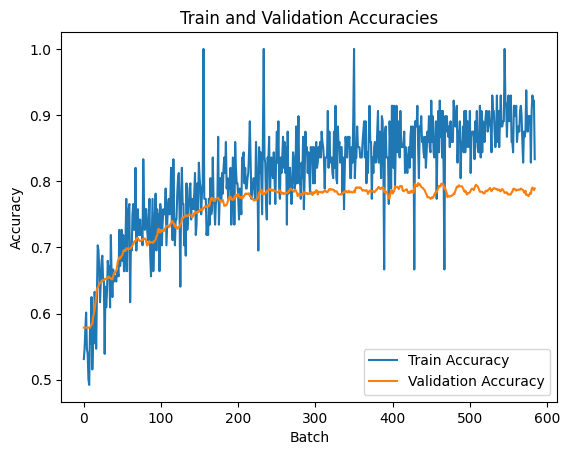

In [496]:
# Compare train and validation accuracy during training
plt.plot(accuracies1, label='Train Accuracy')
plt.plot(val_accuracies1, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies')
plt.legend()
plt.show()

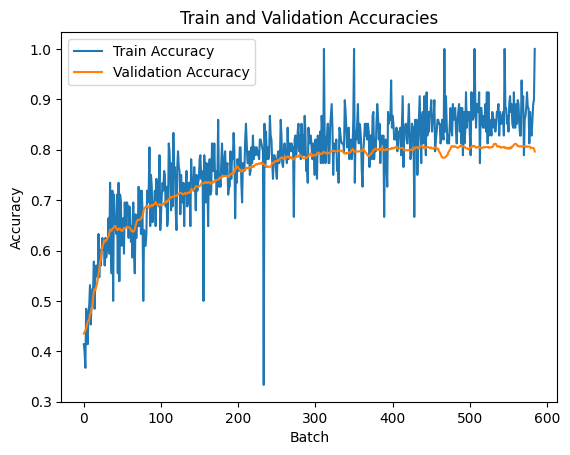

In [497]:
# Compare train and validation accuracy during training
plt.plot(accuracies2, label='Train Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies')
plt.legend()
plt.show()

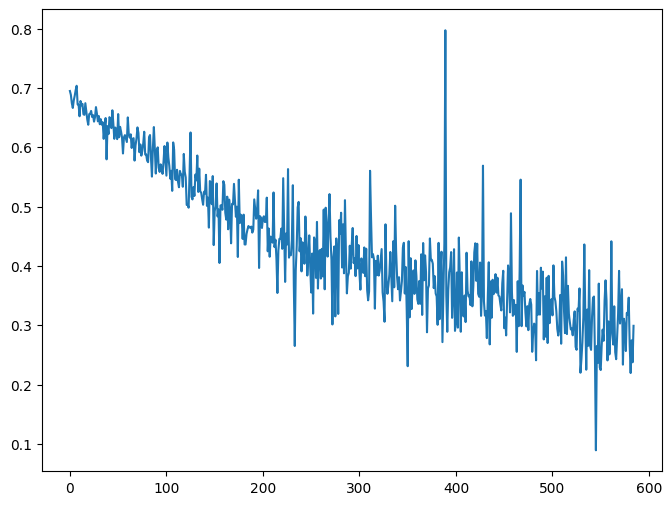

In [498]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(0, len(losses1)), losses1)

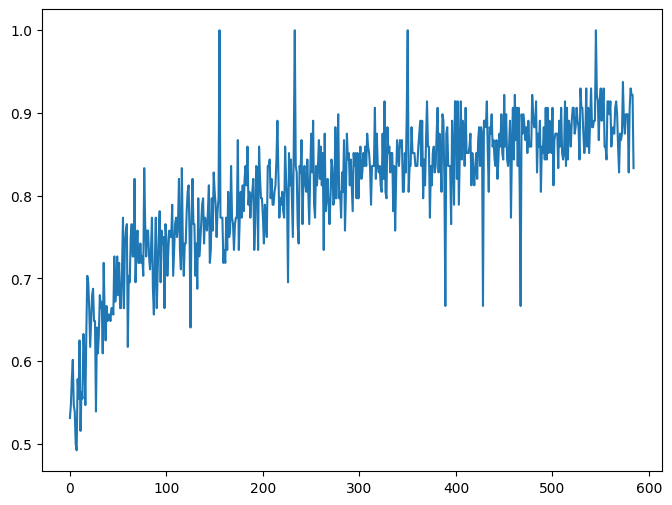

In [499]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(0, len(accuracies1)), accuracies1)

### Evaluate

In [500]:
def evaluate_model(model, dataloader, is_test=True, use_features=False):
    model.eval()
    predictions = []
    true_labels = []
    predicted_probs = []
    input_ids_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_masks, features, labels = batch
            input_ids, attention_masks, features, labels = input_ids.to(device), attention_masks.to(device), features.to(device), labels.to(device)

            if use_features:
              outputs = model(input_ids=input_ids, attention_mask=attention_masks, features=features)
            else:
              outputs = model(input_ids=input_ids, attention_mask=attention_masks)

            if hasattr(outputs, 'logits'):
                # BERT model
                logits = outputs.logits.to(device)
            else:
                # GPT model
                #hidden_states = outputs.last_hidden_state
                #logits = model.classifier(hidden_states)
                logits = outputs.last_hidden_state[:, 0, :].to(device)

            _, predicted_labels = torch.max(logits, dim=1)
            predicted_prob = torch.softmax(logits, dim=1)

            predictions.extend(predicted_labels.cpu().tolist())
            #predictions.extend(F.one_hot(predicted_labels, num_labels).float().cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
            #true_labels.extend(F.one_hot(labels, num_labels).float().cpu().tolist())
            predicted_probs.extend(predicted_prob.cpu().tolist())  # Assuming class 1 is the positive class
            input_ids_list.extend(input_ids.cpu().tolist())

    predicted_probs = np.array(predicted_probs)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)

    if is_test:
      print("Evaluation on test set:")
      precision = precision_score(true_labels, predictions, average='macro')
      recall = recall_score(true_labels, predictions, average='macro')
      f1 = f1_score(true_labels, predictions, average='macro')
      return accuracy, precision, recall, f1, true_labels, predictions, predicted_probs, input_ids_list

    else:
        return accuracy, true_labels, predictions, predicted_probs, input_ids_list

In [501]:
# Evaluate model1
accuracy1, precision1, recall1, f11, true_labels1, predictions1, predicted_probs1, input_ids_list1 = evaluate_model(model1, testloader, use_features=True)

# Print results
print(f"Accuracy: {accuracy1:.4f}")
print(f"Precision: {precision1:.4f}")
print(f"Recall: {recall1:.4f}")
print(f"F1 Score: {f11:.4f}")

Evaluation on test set:
Accuracy: 0.8049
Precision: 0.8074
Recall: 0.7924
F1 Score: 0.7967


In [502]:
# Evaluate model2
accuracy2, precision2, recall2, f12, true_labels2, predictions2, predicted_probs2, input_ids_list2 = evaluate_model(model2, testloader)

# Print results
print(f"Accuracy: {accuracy2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Recall: {recall2:.4f}")
print(f"F1 Score: {f12:.4f}")

Evaluation on test set:
Accuracy: 0.8022
Precision: 0.7981
Recall: 0.7993
F1 Score: 0.7987


## Interpretation

In [ ]:
def find_most_significant_words(input_ids_list, predicted_probs):
    token_scores = {}

    # Aggregate the predicted probabilities for each token across examples
    for example_probs in predicted_probs:
        for token_index, prob_positive_class in enumerate(example_probs):
            if token_index not in token_scores:
                token_scores[token_index] = prob_positive_class
            else:
                token_scores[token_index] += prob_positive_class

    # Sort the token scores in descending order
    sorted_scores = sorted(token_scores.items(), key=lambda x: x[1], reverse=True)

    # Get the top 10 most significant words
    top_10_tokens = [token_index for token_index, _ in sorted_scores[:10]]
    top_10_words = [tokenizer.convert_ids_to_tokens(input_ids[token_index]) for token_index in top_10_tokens]

    return top_10_words

In [ ]:
top_words = find_most_significant_words(input_ids_list, predicted_probs)
print(top_words)

## Visualizations

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import seaborn as sns

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels):
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a heatmap for the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

    # Set axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

plot_confusion_matrix(true_labels, predictions)

In [ ]:
def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs[:, 1])
    auc = roc_auc_score(true_labels, predicted_probs[:, 1])

    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(true_labels, predicted_probs)

## GPT

In [503]:
from transformers import GPT2Model, GPT2Tokenizer, GPT2Config, OpenAIGPTTokenizer 

In [504]:
# Load the pre-trained model
model_name_gpt = 'distilgpt2'
#model_name_gpt = 'openai-gpt'
model_config_gpt = GPT2Config.from_pretrained(model_name_gpt)

In [505]:
# Load pre-trained tokenizer
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name_gpt)
#tokenizer_gpt = OpenAIGPTTokenizer.from_pretrained(model_name_gpt)

tokenizer_gpt.add_special_tokens({'pad_token': '[PAD]'})

model_config_gpt.vocab_size = len(tokenizer_gpt)

gpt = GPT2Model.from_pretrained(model_name_gpt, config=model_config_gpt, ignore_mismatched_sizes=True)

# Replace the pre-trained head with a new one
last_state_dim_gpt = model_config_gpt.hidden_size
gpt.classifier = nn.Linear(last_state_dim_gpt, num_labels)

# Move the model to the appropriate device
gpt.to(device)

# Build train dataset
train_input_ids_gpt, train_attention_masks_gpt, train_features_tensor_gpt = preprocess(train_texts, tokenizer_gpt, train_features)
train_labels_gpt = torch.tensor(train_labels.tolist()).to(device)
train_dataset_gpt = torch.utils.data.TensorDataset(train_input_ids_gpt, train_attention_masks_gpt, train_features_tensor_gpt, train_labels_gpt)

# Split the dataset into train and validation sets
train_size_gpt = int(0.8 * len(train_dataset_gpt))
val_size_gpt = len(train_dataset_gpt) - train_size_gpt
train_dataset_gpt, val_dataset_gpt = torch.utils.data.random_split(train_dataset_gpt, [train_size_gpt, val_size_gpt])

# Build test dataset
test_input_ids_gpt, test_attention_masks_gpt, test_features_tensor_gpt = preprocess(test_texts, tokenizer_gpt, test_features)
test_labels_gpt = torch.tensor(test_labels.tolist()).to(device)
test_dataset_gpt = torch.utils.data.TensorDataset(test_input_ids_gpt, test_attention_masks_gpt, test_features_tensor_gpt, test_labels_gpt)

# Define batch size
batch_size_gpt = 32

# Build DataLoaders
trainloader_gpt = torch.utils.data.DataLoader(train_dataset_gpt, batch_size=batch_size_gpt, shuffle=True)
testloader_gpt = torch.utils.data.DataLoader(test_dataset_gpt, batch_size=batch_size_gpt, shuffle=False)
valloader_gpt = torch.utils.data.DataLoader(val_dataset_gpt, batch_size=batch_size_gpt, shuffle=False)

Some weights of GPT2Model were not initialized from the model checkpoint at distilgpt2 and are newly initialized because the shapes did not match:
- transformer.wte.weight: found shape torch.Size([50257, 768]) in the checkpoint and torch.Size([50258, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [506]:
# Define learning rate and number of epochs
learning_rate_gpt = 1e-3
epochs_gpt = 50
patience_gpt = 2

# Define the optimizer and criterion
optimizer_gpt = optim.AdamW(gpt.parameters(), lr=learning_rate_gpt)
criterion_gpt = nn.CrossEntropyLoss()

In [507]:
# Train model
losses_gpt, accuracies_gpt, val_accuracies_gpt = train_model(gpt, optimizer_gpt, criterion_gpt, trainloader_gpt, valloader_gpt)

Train Epoch: 0	Loss: 0.680055	Train Accuracy: 0.6667	Validation Accuracy: 0.6067
Train Epoch: 1	Loss: 1.009328	Train Accuracy: 0.0000	Validation Accuracy: 0.6199
Train Epoch: 2	Loss: 0.396880	Train Accuracy: 0.8333	Validation Accuracy: 0.6264
Train Epoch: 3	Loss: 0.535651	Train Accuracy: 0.8333	Validation Accuracy: 0.6379
Train Epoch: 4	Loss: 0.701236	Train Accuracy: 0.5000	Validation Accuracy: 0.6527
Train Epoch: 5	Loss: 0.239455	Train Accuracy: 1.0000	Validation Accuracy: 0.6552
Train Epoch: 6	Loss: 0.567627	Train Accuracy: 0.8333	Validation Accuracy: 0.5657


KeyboardInterrupt: ignored

In [ ]:
# Compare train and validation accuracy during training
plt.plot(accuracies_gpt, label='Train Accuracy')
plt.plot(val_accuracies_gpt, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracies')
plt.legend()
plt.show()

In [509]:
# Evaluate model
accuracy_gpt, precision_gpt, recall_gpt, f1_gpt, true_labels_gpt, predictions_gpt, predicted_probs_gpt, input_ids_list_gpt = evaluate_model(gpt, testloader_gpt)

# Print results
print(f"Accuracy: {accuracy_gpt:.4f}")
print(f"Precision: {precision_gpt:.4f}")
print(f"Recall: {recall_gpt:.4f}")
print(f"F1 Score: {f1_gpt:.4f}")

Evaluation on test set:
Accuracy: 0.6156
Precision: 0.6062
Recall: 0.6046
F1 Score: 0.6051


## Logistic Regression

In [451]:
import re
from sklearn.preprocessing import StandardScaler

In [516]:
logreg = LogisticRegression(max_iter=8000, solver='lbfgs')

In [511]:
def extract_features(text):
    # Mean word length
    words = text.split()
    mean_word_length = sum(len(word) for word in words) / len(words)

    # Character count
    character_count = len(text)

    # Punctuation count
    punctuation_count = len(re.findall(r'[^\w\s]', text))

    return mean_word_length, character_count, punctuation_count

In [517]:
# Apply feature extraction to the train and test texts
train_features_text = [extract_features(text) for text in train_texts]
test_features_text = [extract_features(text) for text in test_texts]

# Convert the features to a NumPy array and standardize the values if needed
train_features_text = np.array(train_features_text)
test_features_text = np.array(test_features_text)

# Concatenate the text features and additional features
train_features_all = np.concatenate((train_features_text, train_features), axis=1)
test_features_all = np.concatenate((test_features_text, test_features), axis=1)

# Scale the input features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_all)
test_features_scaled = scaler.transform(test_features_all)

In [513]:
for i in range(2):
    print("Train Feature", i + 1)
    print(train_features_all[i])

Train Feature 1
[6.40000000e+00 1.10000000e+02 8.00000000e+00 4.03897732e-01
 7.37980679e-02 5.22304177e-01 9.33222234e-01]
Train Feature 2
[6.83333333e+00 1.40000000e+02 8.00000000e+00 2.27039933e-01
 8.10099244e-02 6.91950202e-01 9.64934170e-01]


In [518]:
# Train logistic regression model
logreg.fit(train_features_scaled, train_labels)

# Make predictions using logistic regression model
logreg_predictions = logreg.predict(test_features_scaled)

# Evaluate logistic regression model
logreg_accuracy = accuracy_score(test_labels, logreg_predictions)
print("Logistic Regression Accuracy:", logreg_accuracy)

Logistic Regression Accuracy: 0.6491458607095927


## Combine results

In [525]:
# Average the predicted probabilities from BERT and logistic regression
logreg_probs = logreg.predict_proba(test_features_all)[:, 1]  # Extract the probabilities of the positive class
logreg_probs = logreg_probs.reshape(-1, 1)  # Reshape to match the shape of BERT's predicted probabilities

combined_probs = (predicted_probs2 + logreg_probs + predicted_probs1) / 3

# Choose the class with the highest average probability
combined_predictions = np.argmax(combined_probs, axis=1)

# Calculate the accuracy of the combined predictions
combined_accuracy = accuracy_score(test_labels, combined_predictions)

print('Combined Model Accuracy: {:.4f}'.format(combined_accuracy))

Combined Model Accuracy: 0.8134


### Predict Disaster or Not

Use trained model to predict if a tweet is about a disaster or not.

In [526]:
def preprocess_TA(text, tokenizer):
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
  return inputs['input_ids'].to(device), inputs['attention_mask'].to(device)

def predict_disaster_TA(texts, model, tokenizer):
  model.eval() # Set the model to evaluation mode
  input_ids, attention_mask = preprocess_TA(texts, tokenizer)

  with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask) # Get the model outputs
    logits = outputs.logits # Get the logits from the model outputs
    probabilities = F.softmax(logits, dim=1)
    disasters = torch.argmax(probabilities, dim=1).squeeze()

  return disasters, probabilities

In [527]:
# Call the predict_sentiment_TA function
text = "Was in NYC last week!"
disaster, probabilities = predict_disaster_TA(text, model2, tokenizer)

print(f"Disaster: {disaster}")
print(f"Probabilities: {probabilities}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Disaster: 0
Probabilities: tensor([[0.8206, 0.1794]], device='cuda:0')
